# LLM - Detect AI Generated Text
# (NN) Dense connected Neural Network

## Import

In [1]:
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
from sklearn.metrics import roc_curve ,precision_recall_curve,auc,confusion_matrix,ConfusionMatrixDisplay
import keras


2024-01-22 16:11:40.570089: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 16:11:40.570123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 16:11:40.600742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 16:11:40.664996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 16:11:41.777968: W tensorflow/compiler/tf2

In [2]:
train_dataset=pd.read_csv("../data/lexp/pre_processed/train.csv")
train_dataset

,id,prompt_id,generated,0,1,2,3,4,5,6,...,96,97,98,99,normalized_norm,token_num,sent_num,punct_sym,apostrof_sym,unk_num
0,36099,21,1,0.092587,-0.115240,-0.018131,0.021178,-0.050177,0.043627,0.004209,...,0.004295,0.059599,0.054954,-0.148500,0.292739,0.003686,0.000903,0.000966,0.004742,0
1,16917,21,0,-0.084223,-0.029749,-0.021067,0.126892,-0.057582,0.017025,0.083727,...,0.021344,0.049156,-0.010343,-0.052833,0.375338,0.003686,0.005059,0.004038,0.004742,0
2,25047,21,0,-0.009041,-0.095040,0.041203,-0.042403,-0.046674,-0.112742,-0.100110,...,0.007299,-0.095196,0.041735,0.032644,0.391563,0.003686,0.003794,0.003248,0.000000,0
3,41920,0,1,-0.050899,0.002412,-0.094447,0.025261,-0.186032,-0.133531,-0.021346,...,-0.000328,-0.003083,0.024195,-0.168425,0.407825,0.003686,0.003614,0.004740,0.000000,0
4,29450,21,1,-0.030859,0.037719,-0.068962,0.096798,-0.022595,0.072426,-0.000246,...,0.099833,0.051102,-0.058864,-0.038661,0.420152,0.003686,0.003433,0.002458,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29433,5496,21,0,-0.016289,0.123990,0.023495,0.030333,0.039487,0.099832,0.080682,...,-0.126559,0.015553,0.064629,-0.037617,0.285789,0.003686,0.003794,0.004565,0.000000,0
29434,14563,21,0,-0.024276,-0.048697,0.044264,-0.057648,-0.018264,-0.019275,0.019396,...,-0.073636,0.085961,0.114446,-0.045751,0.292714,0.003686,0.004517,0.003160,0.000000,0
29435,58657,21,1,0.063875,-0.115294,-0.076459,0.063014,-0.068307,-0.058009,0.106011,...,0.023818,0.014501,0.174255,-0.092864,0.281899,0.003686,0.004878,0.005618,0.002371,0
29436,49379,21,1,-0.075974,-0.139476,0.034989,0.072057,-0.193817,-0.005860,-0.034723,...,0.001473,0.065966,0.047369,-0.100668,0.235171,0.003686,0.002891,0.003248,0.000000,0


## Random Downsampling

In [3]:
def downsampling(X_train,y_train,rand_state,ratio):
    # Concatenate X_train and y_train for ease of downsampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # Identify the class with the majority of instances
    majority_class = train_data[y_train.name].value_counts().idxmax()

    # Separate instances of each class
    majority_class_data = train_data[train_data[y_train.name] == majority_class]
    minority_class_data = train_data[train_data[y_train.name] != majority_class]


    currRatio = len(majority_class_data) / len(minority_class_data)
    if(currRatio<=ratio):
        raise ValueError(f"El ratio de entrada debe ser menor al ratio actual.r={currRatio}")


    # Downsample the majority class to match the number of instances in the minority class
    downsampled_majority_class_data = resample(
        majority_class_data,
        replace=False,
        n_samples=math.floor(ratio*len(minority_class_data)),
        random_state=rand_state
    )

    # Combine the downsampled majority class with the minority class
    downsampled_train_data = pd.concat([downsampled_majority_class_data, minority_class_data])

    # Shuffle the data to avoid any order-based patterns
    downsampled_train_data = downsampled_train_data.sample(frac=1, random_state=rand_state)

    # Separate X_train and y_train after downsampling
    X_train_downsampled = downsampled_train_data.drop(columns=[y_train.name])
    y_train_downsampled = downsampled_train_data[y_train.name]

    return X_train_downsampled, y_train_downsampled

## ROC AUC curve

In [4]:
def ROCcurves(model,x_val,y_val):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    y_pred = model.predict(x_val).ravel()
    fpr, tpr , _ = roc_curve(y_val,  y_pred)
    auc_ss = auc(fpr,tpr)
    precision, recall, _ = precision_recall_curve(y_val,  y_pred)
    auc_pr = auc(recall, precision)

    # Primer subgráfico
    axs[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='AUC = 0.50')
    axs[0].plot(fpr,tpr, label='ROC curve', color='blue')
    axs[0].set_title(f'ROC curve = {round(auc_ss,3)}')
    axs[0].set_xlabel('FalsePositiveRate')
    axs[0].set_ylabel('TruePositiveRate')
    axs[0].legend()
    # Segundo subgráfico
    axs[1].plot([0, 1], [0,0], color='gray', lw=1, linestyle='--', label='AUC = 0.0')
    axs[1].plot(recall, precision, label='ROC-RP curve', color='orange')
    axs[1].set_title(f'ROC-RP curve = {round(auc_pr,3)}')
    axs[1].set_xlabel('Recall')
    axs[1].set_ylabel('Precision')
    axs[1].legend()
    plt.show()



## Arquitecture

In [122]:
input = keras.Input(shape=(train_dataset.shape[1]-2,))
x = keras.layers.Dense(train_dataset.shape[1]-2,activation="relu",kernel_regularizer=keras.regularizers.L1L2(l1=0.0, l2=0))(input)
#x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(1000,activation="relu")(x)
output = keras.layers.Dense(1,activation="sigmoid")(x)

model = keras.Model(input,output)

model.compile(optimizer='adam',
               loss=keras.losses.BinaryCrossentropy(),
               metrics=[keras.metrics.AUC()])

## Training

In [123]:
rand_state= random.randint(0,1000)
#NN training with 10-fold cross-validation stratified with random under-sampling technic for imbalanced data
X = train_dataset.drop(["id","generated"],axis=1)
Y = train_dataset["generated"]
folds = StratifiedKFold(10,shuffle=True,random_state=rand_state)
for fold, (train_index, val_index) in enumerate(folds.split(X,Y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

    X_train_dwns, y_train_dwns = downsampling(X_train,y_train,rand_state,ratio=1)

    #print(f"Fold {fold + 1}: Train {len(train_index)} samples, Validation {len(val_index)} samples")
    #print(f"TRAIN:({y_train[y_train==0].size}:{y_train[y_train==1].size})")
    print(f"DOWNSAMPLED:({y_train_dwns[y_train_dwns==0].size}:{y_train_dwns[y_train_dwns==1].size})")
    #print(f"VAL:({y_val[y_val==0].size}:{y_val[y_val==1].size})")

    model.fit(X_train_dwns,
                y_train_dwns,
                validation_data=(X_val,y_val),
                batch_size=100,
                epochs=3)

DOWNSAMPLED:(9967:9967)
Epoch 1/3
200/200 [==============================] - 1s 5ms/step - loss: 0.6183 - auc_20: 0.7078 - val_loss: 0.5509 - val_auc_20: 0.7928
Epoch 2/3
200/200 [==============================] - 1s 4ms/step - loss: 0.5338 - auc_20: 0.8054 - val_loss: 0.5179 - val_auc_20: 0.8247
Epoch 3/3
200/200 [==============================] - 1s 4ms/step - loss: 0.4899 - auc_20: 0.8416 - val_loss: 0.5579 - val_auc_20: 0.8411
DOWNSAMPLED:(9967:9967)
Epoch 1/3
200/200 [==============================] - 1s 4ms/step - loss: 0.4553 - auc_20: 0.8659 - val_loss: 0.5314 - val_auc_20: 0.8693
Epoch 2/3
200/200 [==============================] - 1s 4ms/step - loss: 0.4276 - auc_20: 0.8828 - val_loss: 0.5009 - val_auc_20: 0.8820
Epoch 3/3
200/200 [==============================] - 1s 4ms/step - loss: 0.4117 - auc_20: 0.8918 - val_loss: 0.4321 - val_auc_20: 0.8913
DOWNSAMPLED:(9967:9967)
Epoch 1/3
200/200 [==============================] - 1s 4ms/step - loss: 0.3983 - auc_20: 0.8988 - val_los

920/920 [==============================] - 2s 2ms/step


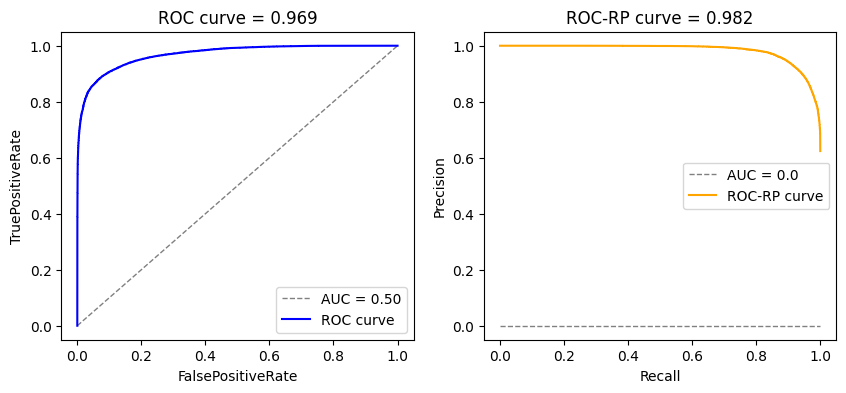

In [129]:
ROCcurves(model,X,Y)

920/920 [==============================] - 1s 1ms/step


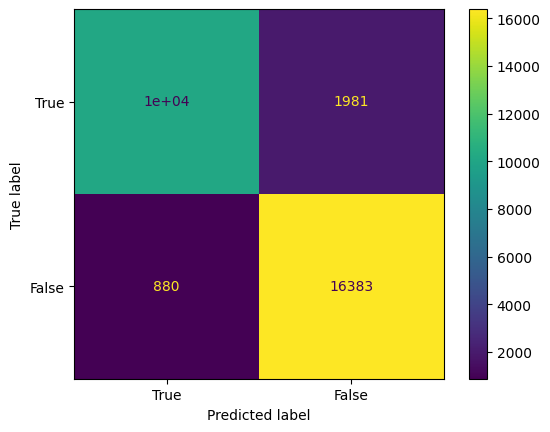

In [125]:
pred = list(map(lambda pred : 1 if pred > 0.5 else 0,model.predict(x=X)))
display = ConfusionMatrixDisplay(confusion_matrix(pred,Y),display_labels=["True","False"])
display.plot()

In [126]:
model.predict(x=pd.DataFrame(X.iloc[1385]).transpose())

1/1 [==============================] - 0s 14ms/step


array([[0.99962413]], dtype=float32)

# Test model

1380/1380 [==============================] - 2s 2ms/step


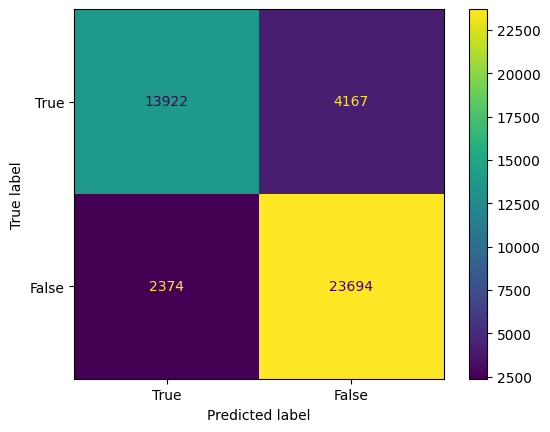

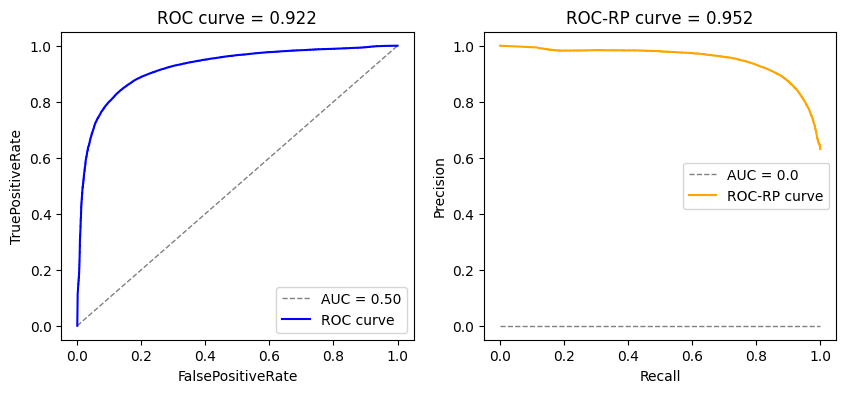

In [130]:

test_dataset = pd.read_csv("../data/lexp/pre_processed/test.csv")
X_test = test_dataset.drop(["id","generated"],axis=1)
Y_test = test_dataset[["generated"]]
pred = model.predict(x=X_test)
pred = [1 if p>=0.5 else 0 for p in pred]
ConfusionMatrixDisplay(confusion_matrix(pred,Y_test),display_labels=["True","False"]).plot()
ROCcurves(model,X_test,Y_test)


## Save model weights
Overfitting 2: 1 layer with 1000, 13 epochs & 100 batch_size
Regularized: equal to O2, but with

In [128]:
#model.save("../data/NN/weight(last experiment).h5")